In [10]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('data\\star_classification.csv')

In [11]:
df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [12]:
encoder = LabelEncoder()
df["class"] = encoder.fit_transform(df["class"])
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0,0.116123,6121,56187,842


In [13]:
cols_to_drop = ['obj_ID', 'spec_obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'plate', 'fiber_ID', 'MJD']
for col in cols_to_drop:
  df = df.drop(col, axis=1)
df.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0,0.116123


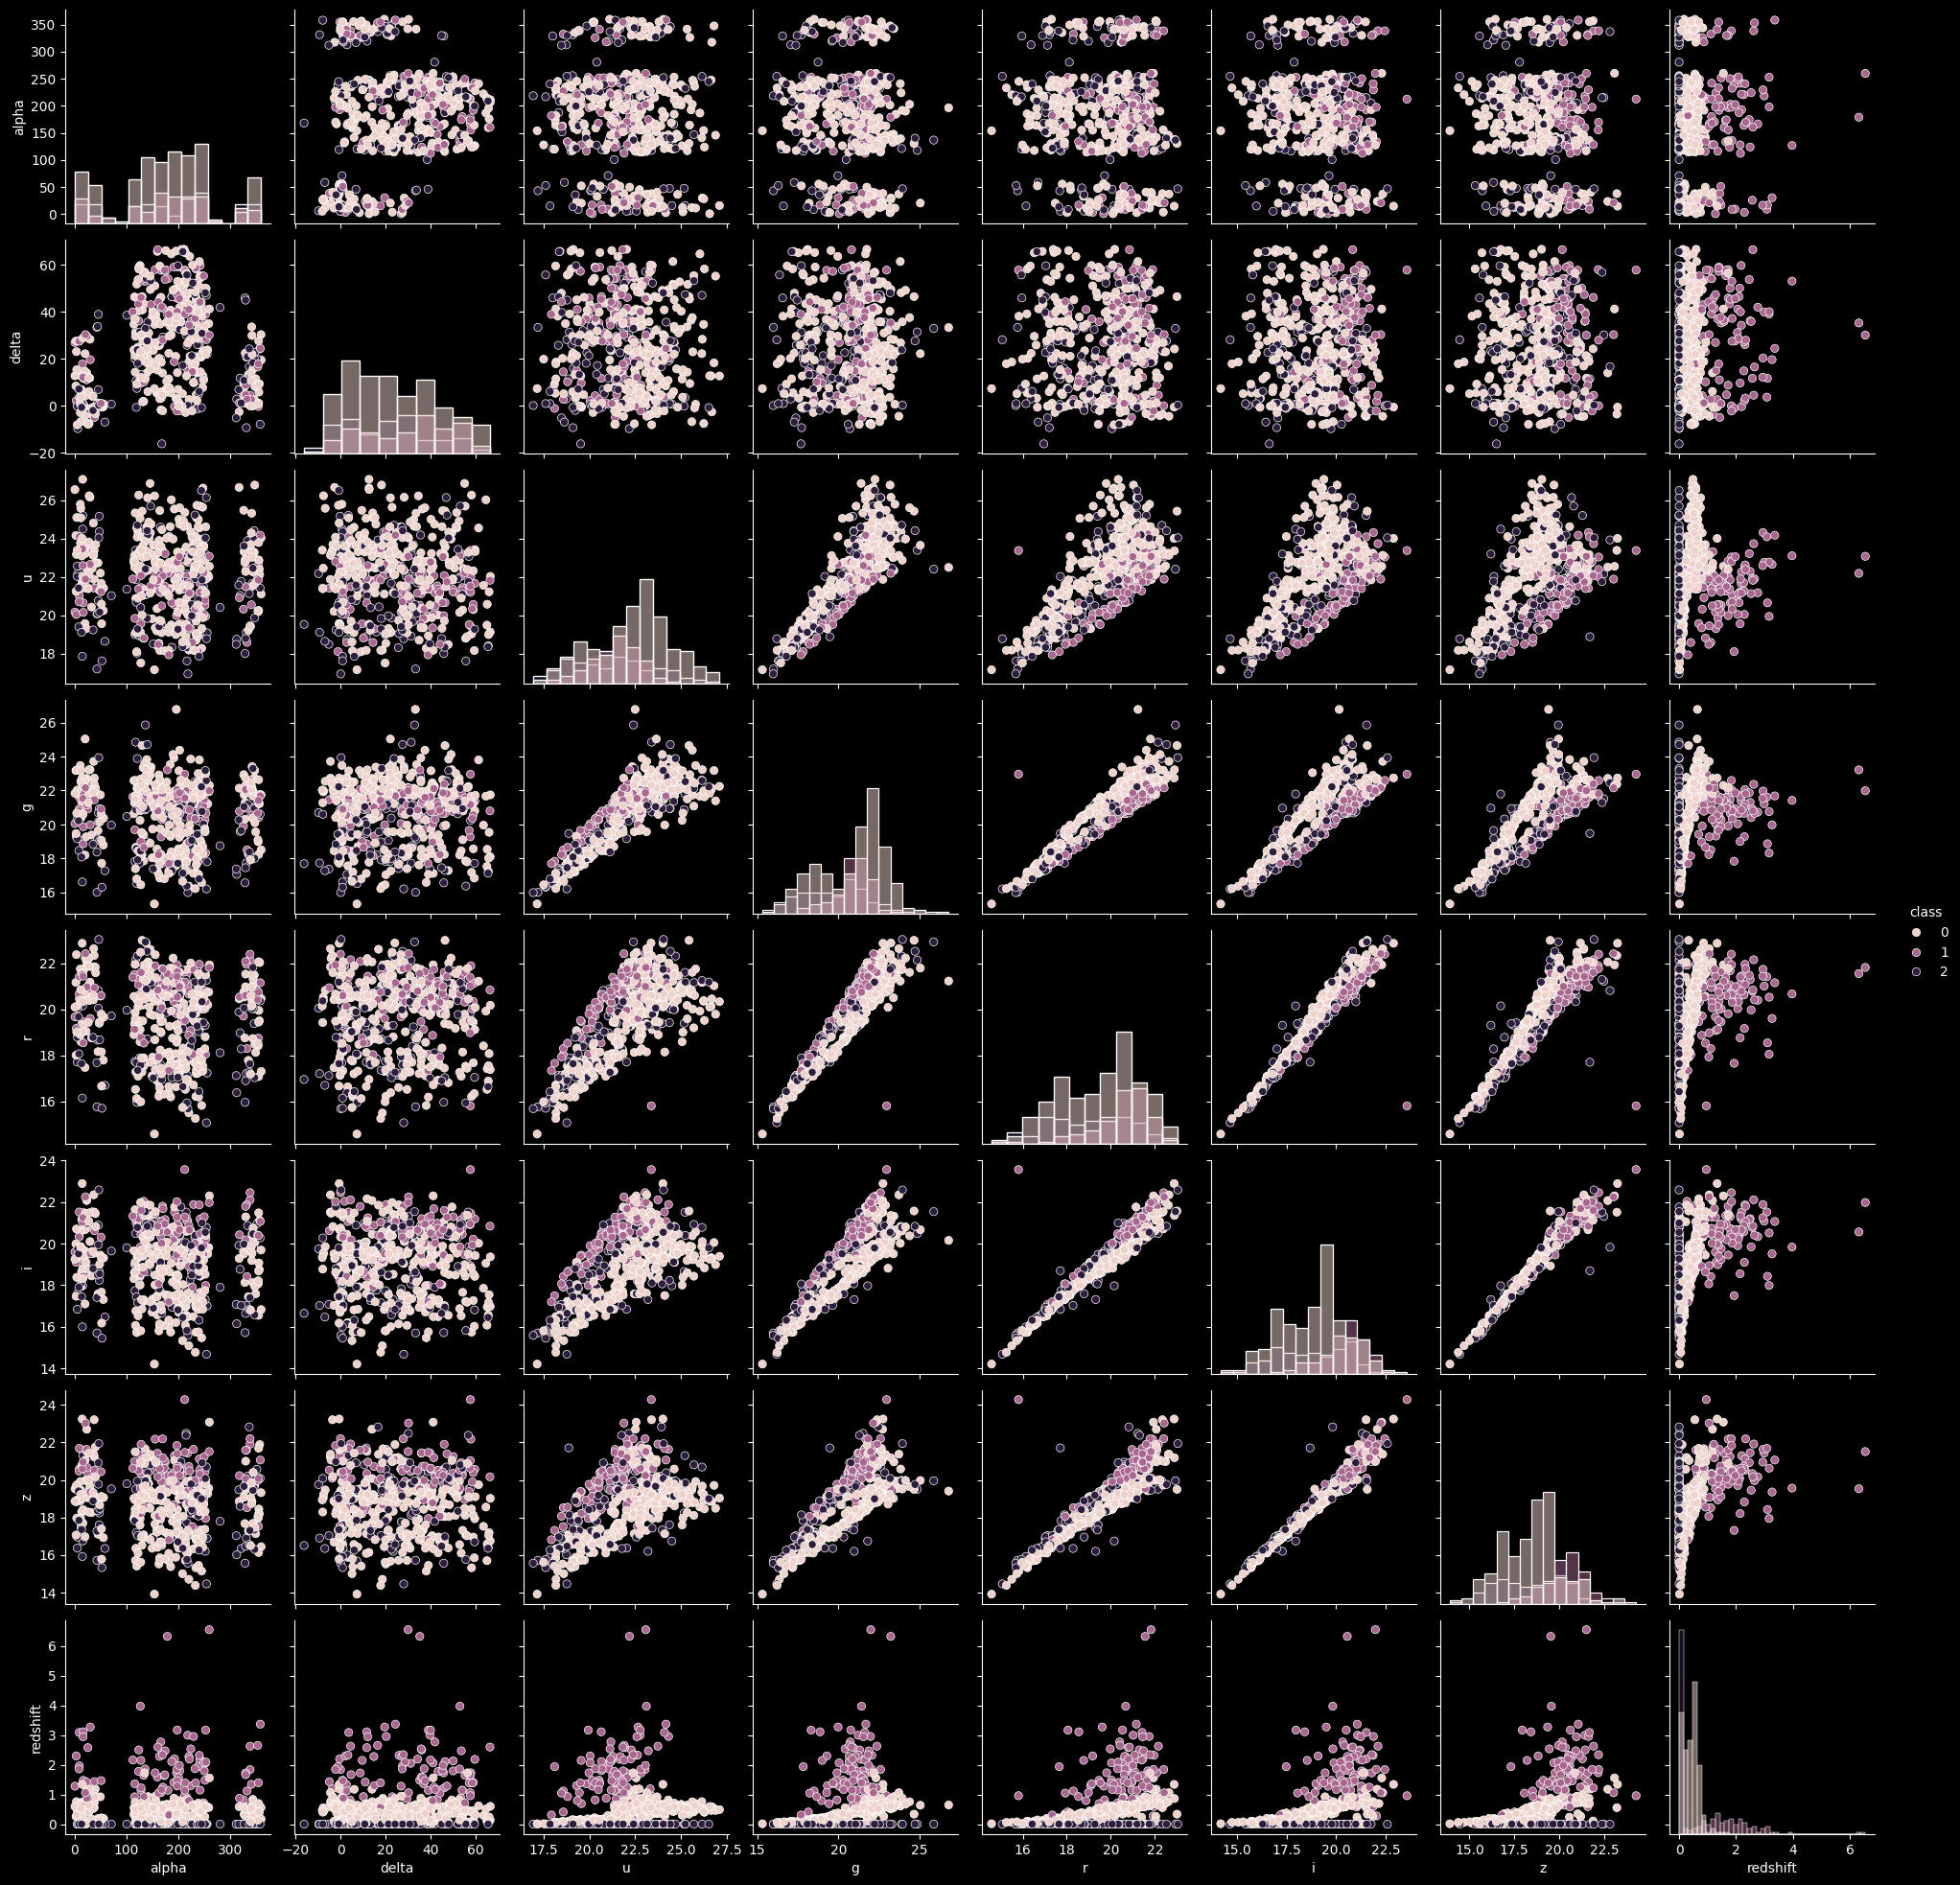

In [14]:
#pair plot for df
sns.pairplot(df.sample(500), hue="class", diag_kind="hist")

In [15]:
X = df.drop("class", axis=1)
y = df["class"]
X.info(), y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   redshift  100000 non-null  float64
dtypes: float64(8)
memory usage: 6.1 MB
<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: class
Non-Null Count   Dtype
--------------   -----
100000 non-null  int64
dtypes: int64(1)
memory usage: 781.4 KB


(None, None)

In [17]:
models = {
  "LightGBM": LGBMClassifier(
      n_estimators=200,
      max_depth=5,verbose=-1
  ),
  "Random Forest": RandomForestClassifier(
      n_estimators=200,
      max_depth=50
  ),
  "XGBoost": XGBClassifier(
      verbosity=0,
      n_estimators=280,
      max_depth=5,
  )
}

results = {}
for model_name in models:
  results[model_name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}


In [18]:
splits = 10
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"\nFold {fold_idx + 1}/{splits}")
  Scaler = StandardScaler()
  # Get the train & test split for this fold
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  X_train = Scaler.fit_transform(X_train)
  X_test = Scaler.transform(X_test)
  # Train & Validate Models
  for model_name, model in models.items():

    print(f"Training {model_name}...")

    # Fit the model on train data
    model.fit(X_train, y_train)

    # Use the model to predict the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    results[model_name]['accuracy'].append(accuracy)
    results[model_name]['f1'].append(f1)
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)


Fold 1/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 2/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 3/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 4/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 5/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 6/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 7/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 8/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 9/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...

Fold 10/10
Training LightGBM...


c:\Users\shawg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training Random Forest...
Training XGBoost...


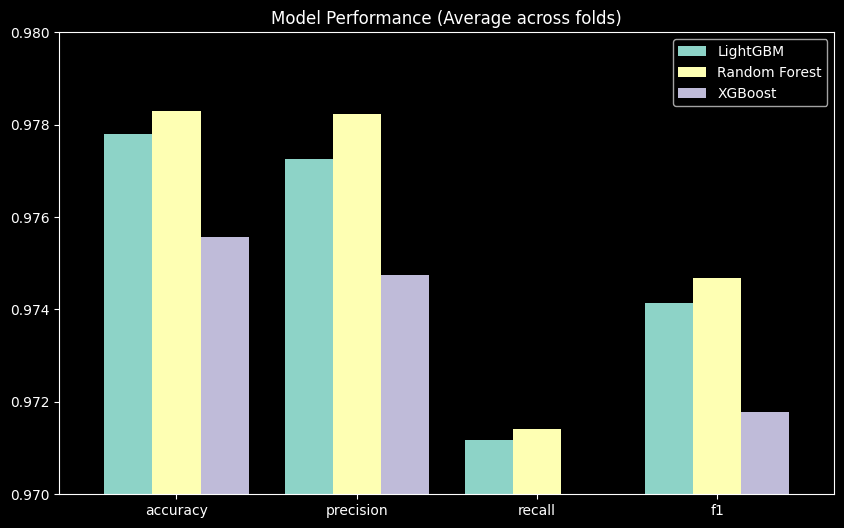

In [35]:

results = pd.DataFrame(results)
results_clean = results.map(lambda x: np.mean(x)) #type: ignore
ax = results_clean.plot(kind='bar', figsize=(10, 6), width=0.8, rot=0)
ax.set_ylim(0.97, 0.98) 
ax.set_title("Model Performance (Average across folds)")
plt.show()

In [36]:
for model_name in results:
  print(f"\n{model_name}:")
  print(f"  Accuracy:  {np.mean(results[model_name]['accuracy']):.4f}")
  print(f"  F1-Score:  {np.mean(results[model_name]['f1']):.4f}")
  print(f"  Precision: {np.mean(results[model_name]['precision']):.4f}")
  print(f"  Recall:    {np.mean(results[model_name]['recall']):.4f}")



LightGBM:
  Accuracy:  0.9778
  F1-Score:  0.9741
  Precision: 0.9773
  Recall:    0.9712

Random Forest:
  Accuracy:  0.9783
  F1-Score:  0.9747
  Precision: 0.9782
  Recall:    0.9714

XGBoost:
  Accuracy:  0.9756
  F1-Score:  0.9718
  Precision: 0.9747
  Recall:    0.9690
